<a href="https://colab.research.google.com/github/NamChangseok/airbnb-clone/blob/master/SEOULBUSAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install category_encoders
!pip install shap

     |████████████████████████████████| 86 kB 4.8 MB/s 
     |████████████████████████████████| 564 kB 25.6 MB/s 


In [4]:
import pandas as pd
import numpy as np
import sklearn
import xgboost
import shap
import re
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from category_encoders import TargetEncoder

from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer 
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [5]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [6]:
train=pd.read_csv('/gdrive/MyDrive/AIBOOT_CAMP/Section2/seoul_realstate_daicon/train.csv')

아파트의 이름이 다양하여 같은 브랜드의 아파트임을 묶기 위해 
아래와 같은 코드를 참조하여 사용하고 

훈련과 테스트 데이터를 분리시켜주었다.

In [7]:
regex = "\(.*\)|\s-\s.*"
for i in range(len(train)):
   train.at[i, 'apt'] = re.sub(regex, '', train.at[i, 'apt'])
train,test=train_test_split(train,train_size=0.8,test_size=0.2, random_state=42)

In [8]:
print(train.shape,test.shape)

(973242, 13) (243311, 13)


데이터의 크기가 약 백만개가량이 되는 것을 볼 수 있다.


데이터의 모양과 결측치가 있는지 살펴보았다


In [9]:
train.head(3)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
110396,110396,9610,서울특별시,정릉동,239,정릉풍림아이원,정릉동 239 정릉풍림아이원,114.75,2005,201105,11~20,6,42000
997293,997293,9825,부산광역시,연산동,2220,주공,연산동 2220 주공,69.08,1986,200804,21~30,9,16500
770780,770780,572,부산광역시,감만동,225-2,감만현대1차,감만동 225-2 감만현대1차,59.92,1996,201003,21~31,19,7520


In [10]:
train.isnull().sum()
test.isnull().sum() #결측치가 없는 데이터

transaction_id            0
apartment_id              0
city                      0
dong                      0
jibun                     0
apt                       0
addr_kr                   0
exclusive_use_area        0
year_of_completion        0
transaction_year_month    0
transaction_date          0
floor                     0
transaction_real_price    0
dtype: int64

변수가 길어 매번 변수명을 치기 힘드니 이용하기 편한 변수로 변환해주고 타겟을 가격으로 맞춰주고 
데이터의 분포를 살펴보자


지번과 addr항목은 드롭해도 변수에 큰 영향을 줄 것 같지 않기에 제거해주도록 하겠다.


In [11]:
train.columns=['t_id','apt_id','city','dong','jibun','apt','addr','area','y_comple','t_y_m','t_d','flr','price']
test.columns=['t_id','apt_id','city','dong','jibun','apt','addr','area','y_comple','t_y_m','t_d','flr','price']
target='price'

In [12]:
train=train.drop(columns=['t_id','jibun','addr'],axis=1)
test=test.drop(columns=['t_id','jibun','addr'],axis=1)

각 특성들이 타겟과 얼마나 관련있는지 간단히 확인해보기 위해 히트맵을 사용해보았다


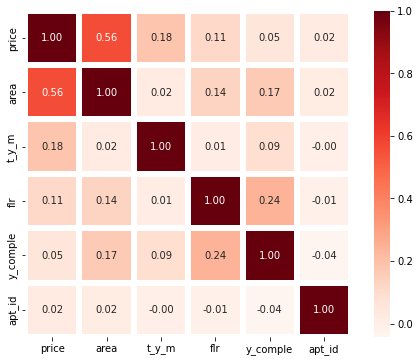

In [13]:
k=train.shape[1]
corrmat=train.corr()
cols=corrmat.nlargest(k,target)[target].index
cm=np.corrcoef(train[cols].values.T)
f,ax=plt.subplots(figsize=(8,6))
sns.heatmap(data=cm,annot=True,square=True,fmt='.2f',linewidths=5,cmap='Reds',yticklabels=cols.values,xticklabels=cols.values)
#면적, 완공년도,

동(주소)도 또한 가격에 영향을 주는 주요소일것 같으니 동을 숫자로 인코딩한후 후 다시 확인해보도록하자


In [14]:
dong_price = train.groupby('dong')[target].agg('mean').sort_values(ascending=False)
dong_price[:10]

dong
장충동1가     227714.285714
압구정동      165088.203166
청암동       158496.704545
용산동5가     155520.043478
회현동2가     139103.851064
반포동       132829.375620
한남동       123099.093704
서빙고동      116254.976471
대치동       116118.253380
남대문로5가    111897.121212
Name: price, dtype: float64

In [15]:
for i, d in enumerate(dong_price.index):
    train.loc[train['dong'] == d, 'dong'] = i
    test.loc[test['dong'] == d, 'dong'] = i

In [16]:
train['dong']=pd.to_numeric(train['dong'])

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 973242 entries, 110396 to 121958
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   apt_id    973242 non-null  int64  
 1   city      973242 non-null  object 
 2   dong      973242 non-null  int64  
 3   apt       973242 non-null  object 
 4   area      973242 non-null  float64
 5   y_comple  973242 non-null  int64  
 6   t_y_m     973242 non-null  int64  
 7   t_d       973242 non-null  object 
 8   flr       973242 non-null  int64  
 9   price     973242 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 81.7+ MB


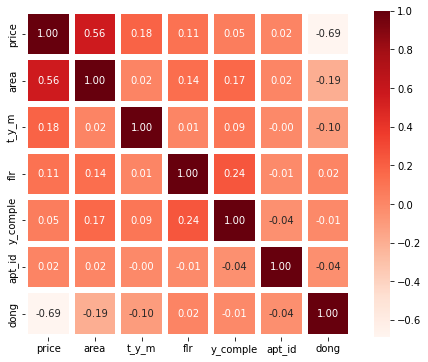

In [17]:
k=train.shape[1]
corrmat=train.corr()
cols=corrmat.nlargest(k,target)[target].index
cm=np.corrcoef(train[cols].values.T)
f,ax=plt.subplots(figsize=(8,6))
sns.heatmap(data=cm,annot=True,square=True,fmt='.2f',linewidths=5,cmap='Reds',yticklabels=cols.values,xticklabels=cols.values)

area(면적)과 flr(층)이 지어진연도, 거래일이 최근이거나 넓을수록 가격에 관련이 있어 보이니 
연관성을 보기 위해 표로 확인해보자.


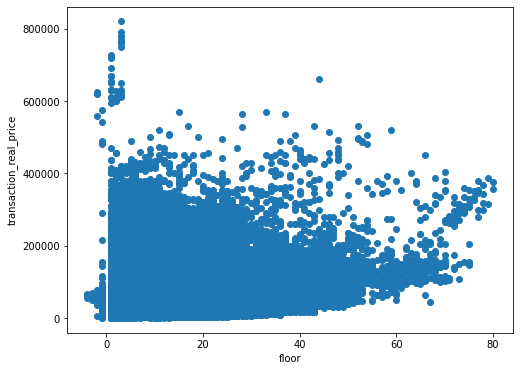

In [18]:
f,ax=plt.subplots(figsize=(8,6))
plt.scatter(train['flr'],train[target])
plt.xlabel('floor')
plt.ylabel('transaction_real_price')
plt.show()

큰 관련은 없어 보인다. 
그렇다면 area에 대해서도 확인해보자.

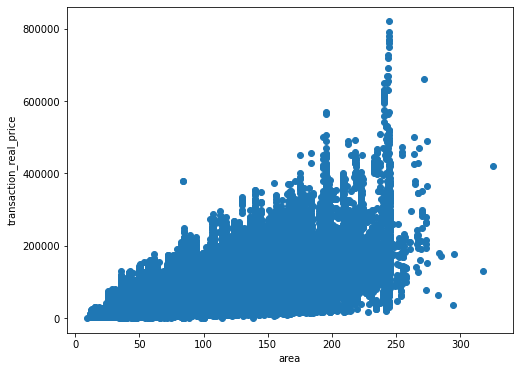

In [19]:
f,ax=plt.subplots(figsize=(8,6))
plt.scatter(train['area'],train[target])
plt.xlabel('area')
plt.ylabel('transaction_real_price')
plt.show()

area는 어느정도 연관성이 있는것을 확인해 볼 수가 있다.
이번엔 건설일자의 연관도를 보겠다. 

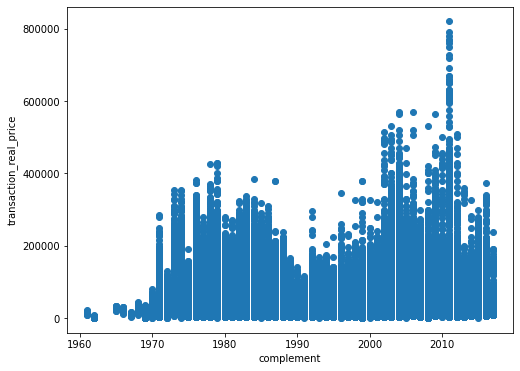

In [20]:
f,ax=plt.subplots(figsize=(8,6))
plt.scatter(train['y_comple'],train[target])
plt.xlabel('complement')
plt.ylabel('transaction_real_price')
plt.show()

건설일자도 최근일수록 가격과 관계가 있다는 것을 볼 수 있다.

이번엔 아파트의 이름들을 묶어 보자

In [21]:
train['apt'].value_counts()[:50]

현대            14147
한신             8162
삼성             5373
대우             5120
신동아            5117
두산             4681
우성             4640
주공2            4578
삼성래미안          4418
벽산             3716
대림             3652
동원로얄듀크         3565
경남             3193
삼환             3129
극동             3057
삼익             2889
롯데캐슬           2869
쌍용             2737
코오롱            2649
오륙도에스케이뷰       2584
한양             2582
성원             2502
파크리오           2479
청구             2368
몰운대            2275
동아             2214
경남아너스빌         2138
현대3            2083
에스케이북한산시티      2052
삼정그린코아         2050
다대동롯데캐슬몰운대     2039
대림e-편한세상       2038
한진             2030
주공5            1973
현대1            1955
미성             1936
엘지메트로시티1       1907
개금주공2          1855
한일유앤아이         1849
삼익비치           1847
롯데낙천대          1828
중앙하이츠          1828
개포주공 1단지       1824
사직쌍용예가         1814
잠실엘스           1796
리센츠            1792
중계그린1단지        1743
관악드림           1671
선사현대아파트        1624
롯데             1622


In [22]:
apt_names=['현대','자이', '푸르지오', '더샵', '롯데캐슬|롯데', '이편한|e편한|e-편한,이-편한',
         '힐스테이트|HILLSTATE', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙','그레이스', '양지', '쌍용', '현대', '한신', '삼성', '대우', '신동아', '두산', '주공',
             '우성', '벽산', '동원로얄듀크','경남', '삼환', '쌍용', '삼익', '대림', '코오롱', '파크리오',
             '엘지', '성원', '잠실', '동궁리치웰', '동성']

In [23]:
train['top10'] = 0
test['top10'] = 0
top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한',
         '힐스테이트', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙']

train['apt'] = train['apt'].fillna('others')
# top 10 시공사면 1, 아니면 0
for i, brand in enumerate(top10):
    train.loc[train['apt'].str.contains(brand), 'top10'] = 1
    test.loc[test['apt'].str.contains(brand), 'top10'] = 1

In [24]:
train.head(1)

,apt_id,city,dong,apt,area,y_comple,t_y_m,t_d,flr,price,top10
110396,9610,서울특별시,254,정릉풍림아이원,114.75,2005,201105,11~20,6,42000,0


In [25]:
# top 10 시공사 키워드와 25개 리스트를 통합
apt_names_list = top10 + apt_names

# `apt_names_list`의 키워드에 해당하는 아파트명이 있는지 여부를 나타내는 새로운 컬럼 생성
train['transformed'] = False
test['transformed'] = False

# `apt_names_list`의 키워드에 아파트명이 포함되면 해당 키워드로 아파트명을 통일함
# 그리고 `transformed` 컬럼값을 True로 변경
for a in apt_names_list:
    train.loc[train['apt'].str.contains(a), 'apt'] = a
    test.loc[test['apt'].str.contains(a), 'apt'] = a
    train.loc[train['apt'].str.contains(a), 'transformed'] = True
    test.loc[test['apt'].str.contains(a), 'transformed'] = True

# 아파트 이름이 변경되지 않았을 경우(`transformed=False` 일 경우) 아파트명을 'others'로 변경
for a in apt_names:
    train.loc[~train['transformed'], 'apt'] = 'others'
    test.loc[~test['transformed'] , 'apt'] = 'others'

In [26]:
"""
# top 10 시공사 키워드와 25개 리스트를 통합
apt_names_list = top10 + apt_names

# `apt_names_list`의 키워드에 해당하는 아파트명이 있는지 여부를 나타내는 새로운 컬럼 생성
train['transformed'] = False
test['transformed'] = False

# `apt_names_list`의 키워드에 아파트명이 포함되면 해당 키워드로 아파트명을 통일함
# 그리고 `transformed` 컬럼값을 True로 변경
for a in tqdm(apt_names_list):
    train.loc[train['apt'].str.contains(a), 'apt'] = a
    test.loc[test['apt'].str.contains(a), 'apt'] = a
    train.loc[train['apt'].str.contains(a), 'transformed'] = True
    test.loc[test['apt'].str.contains(a), 'transformed'] = True

# 아파트 이름이 변경되지 않았을 경우(`transformed=False` 일 경우) 아파트명을 'others'로 변경
for a in tqdm(apt_names):
    train.loc[~train['transformed'], 'apt'] = 'others'
    test.loc[~test['transformed'] , 'apt'] = 'others'
"""

"\n# top 10 시공사 키워드와 25개 리스트를 통합\napt_names_list = top10 + apt_names\n\n# `apt_names_list`의 키워드에 해당하는 아파트명이 있는지 여부를 나타내는 새로운 컬럼 생성\ntrain['transformed'] = False\ntest['transformed'] = False\n\n# `apt_names_list`의 키워드에 아파트명이 포함되면 해당 키워드로 아파트명을 통일함\n# 그리고 `transformed` 컬럼값을 True로 변경\nfor a in tqdm(apt_names_list):\n    train.loc[train['apt'].str.contains(a), 'apt'] = a\n    test.loc[test['apt'].str.contains(a), 'apt'] = a\n    train.loc[train['apt'].str.contains(a), 'transformed'] = True\n    test.loc[test['apt'].str.contains(a), 'transformed'] = True\n\n# 아파트 이름이 변경되지 않았을 경우(`transformed=False` 일 경우) 아파트명을 'others'로 변경\nfor a in tqdm(apt_names):\n    train.loc[~train['transformed'], 'apt'] = 'others'\n    test.loc[~test['transformed'] , 'apt'] = 'others'\n"

In [27]:
print(train['apt'].nunique(), test['apt'].nunique())

35 35


In [28]:
train['apt'].value_counts()

others               515911
현대                    65576
주공                    52668
롯데캐슬|롯데               26700
래미안                   26235
한신                    22054
벽산                    21572
우성                    19453
삼성                    15880
sk|SK|에스케이            15796
두산                    15594
삼익                    14981
푸르지오                  14734
쌍용                    14548
대림                    14517
대우                    14227
이편한|e편한|e-편한,이-편한     11404
신동아                   11269
힐스테이트|HILLSTATE        9554
자이                     9292
엘지                     8753
경남                     8704
코오롱                    6880
아이파크                   6407
성원                     6098
더샵                     5524
동원로얄듀크                 4859
삼환                     4853
파크리오                   2479
잠실                     2076
데시앙                    1797
동성                     1759
양지                      839
그레이스                    174
동궁리치웰                    75
Name: apt, dtype: in

In [29]:
train.reset_index(drop=True)


,apt_id,city,dong,apt,area,y_comple,t_y_m,t_d,flr,price,top10,transformed
0,9610,서울특별시,254,others,114.7500,2005,201105,11~20,6,42000,0,False
1,9825,부산광역시,339,주공,69.0800,1986,200804,21~30,9,16500,0,True
2,572,부산광역시,441,현대,59.9200,1996,201003,21~31,19,7520,0,True
3,5176,부산광역시,425,더샵,84.9056,2004,200908,1~10,13,16400,1,True
4,2700,부산광역시,351,푸르지오,73.1300,2005,201505,11~20,10,34500,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...
973237,8884,서울특별시,165,래미안,114.9300,2007,201104,1~10,9,67000,1,True
973238,2023,서울특별시,221,현대,117.3500,2001,201601,11~20,2,46000,0,True
973239,9604,서울특별시,254,성원,59.9400,2000,201608,1~10,11,26300,0,True
973240,2968,부산광역시,451,others,62.2800,1989,201301,11~20,4,8100,0,False


In [32]:
apt_price=train.groupby('apt')[target].agg('mean').sort_values(ascending=False)


In [33]:
apt_price

apt
잠실                   91611.853083
파크리오                 88638.643405
자이                   79967.694468
래미안                  64045.256489
아이파크                 62867.906821
더샵                   59157.771723
힐스테이트|HILLSTATE      58173.063220
이편한|e편한|e-편한,이-편한    53182.331024
푸르지오                 49618.492195
동궁리치웰                48034.000000
데시앙                  46371.571508
우성                   44945.608081
롯데캐슬|롯데              43001.781835
삼성                   42320.782053
두산                   41889.913621
현대                   41710.588843
신동아                  39974.558790
경남                   39895.601792
쌍용                   38405.704083
대림                   37844.935179
양지                   37227.485101
삼익                   36123.910220
성원                   35777.378649
others               34770.906193
주공                   33947.006133
한신                   33823.926181
코오롱                  33776.993459
sk|SK|에스케이           33404.358319
대우                   32694.401420
그레이스      